## All the imports in size order because I'm weird
Along with their settings

In [1]:
import json
import html
import spacy
import pprint
import pickle
import requests
from bs4 import BeautifulSoup
from collections import Counter
import matplotlib.pyplot as plt
from __future__ import print_function
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_lg')
nlp.add_pipe('spacytextblob')

pp = pprint.PrettyPrinter(indent=4)

### This amazing code is from (https://stackoverflow.com/a/14059645) to search for a specific key while searching through json.
This saved me so much

In [2]:
def find_values(id, json_repr):
    results = []
    def _decode_dict(a_dict):
        try:
            results.append(a_dict[id])
        except KeyError:
            pass
        return a_dict
    json.loads(json_repr, object_hook=_decode_dict) # Return value ignored.
    return results

### Analyzing the comments's lexical diversity
**Spoiler Alert:** *It's surprisingly high*

In [30]:
def lexical_diversity(content):
    words = list(map(lambda x: x.lower(), content.split()))
    return len(set(words))/len(words)

#An averaging function because im lazy
def average_the_list(the_list):
    return sum(the_list)/len(the_list)

# BECOME GIGA BRAIN AND INSTEAD OF HAVING 3 SEPERATE PROCESSES TO MAKE THE DICTIONARY, COMBINE THEM FOR *THE* **MEGA SOUP**

In [4]:
def soupify(raw_ingredients, seating_map):
    portioned_ingredients = []
    #measure the ingredients
    for ingredient in range(len(raw_ingredients)):
        portioned_ingredients.append(BeautifulSoup(raw_ingredients[ingredient].text, 'html5lib'))
    cooked_ingredients = []
    #Break your ingredients up and prepare them seperately as needed
    for portion in range(len(portioned_ingredients)):
        #Get the bowl
        bowl = portioned_ingredients[portion]
        #Gather the wet stuff
        wet_ingredients = bowl.find('div', {'class':'item'})
        #Begin creating the base of the soup
        cooked_ingredients.append(wet_ingredients.find('span', {'class':'weapon-type'}).text.strip().split(' / '))
        #Identify the ingredients
        cooked_ingredients[portion][0] = wet_ingredients.find('h2').text.strip()
        #Some of our meat was fatty. Lets cut that off.
        if portion < 3:
            del cooked_ingredients[portion][1]
        #Gather the dry stuff
        dry_ingredients = bowl.find('ul', {'id':'item-details'}).find_all('strong')
        #Measure with love!
        for handful in range(len(dry_ingredients)):
            #Some of the dry ingredients seem stale. They would throw off the soup, lets fix that.
            if dry_ingredients[handful].text.find(' '):
                #Mix in the dry ingredients
                cooked_ingredients[portion].append(dry_ingredients[handful].text)
    #Prepare the serving bowls
    final_soup = {}
    #Begin serving the soup
    bowl_count = 0
    for location in seating_map:
        final_soup[location] = {'Name':cooked_ingredients[bowl_count][0], 'Slot':cooked_ingredients[bowl_count][1], 'Type':cooked_ingredients[bowl_count][2], 'Damage':cooked_ingredients[bowl_count][3], 'Ammo':cooked_ingredients[bowl_count][4], 'Season':cooked_ingredients[bowl_count][5]}
        bowl_count += 1
        
    #You have made and served soup. Feel the gratitude of the universe for creating and sharing itself.
    return final_soup

# Soupification is the process I made to turn the raw pages of item information into a useable dictionary that can be easily gone through. 
### This is the array of pages that have been turned into Soup for BeautifulSoup to use
    portioned_ingredients = []
    for ingredient in range(len(raw_ingredients)):
        portioned_ingredients.append(BeautifulSoup(raw_ingredients[ingredient].text, 'html5lib'))
### This will hold all the information we need
    cooked_ingredients = []
    for portion in range(len(portioned_ingredients)):
        bowl = portioned_ingredients[portion]
        wet_ingredients = bowl.find('div', {'class':'item'})
### This will grab a specific part of the page that gives me very useful information for catagorizing by different types later
        cooked_ingredients.append(wet_ingredients.find('span', {'class':'weapon-type'}).text.strip().split(' / '))
### This adds the weapons name
        cooked_ingredients[portion][0] = wet_ingredients.find('h2').text.strip()
### Some of the weapons have an unneeded class section that will mess with my array later. I know relying on indexing for information reference is bad practice, but it seemed like a lot of work to make a dictionary to make a dictionary
        if portion < 3:
            del cooked_ingredients[portion][1]
### This will gather more information I need, although its not as easy to isolate what I want. Luckily the website adds a random space I can detect!
        dry_ingredients = bowl.find('ul', {'id':'item-details'}).find_all('strong')
        for handful in range(len(dry_ingredients)):
            if dry_ingredients[handful].text.find(' '):
                cooked_ingredients[portion].append(dry_ingredients[handful].text)
### This is the final dictionary
    final_soup = {}
    bowl_count = 0
### This will add all the information into is correct spot!
    for location in seating_map:
        final_soup[location] = {'Name':cooked_ingredients[bowl_count][0], 'Slot':cooked_ingredients[bowl_count][1], 'Type':cooked_ingredients[bowl_count][2], 'Damage':cooked_ingredients[bowl_count][3], 'Ammo':cooked_ingredients[bowl_count][4], 'Season':cooked_ingredients[bowl_count][5]}
        bowl_count += 1
# *You have made and served soup. Feel the gratitude of the universe for creating and sharing itself.*
    return final_soup

### I am strange and prefer to init all my vars (except the ones that get reset every time I run the function)

In [5]:
id_list = []
completed_api = []
completed_html = []

### Grab all your pickle jars! It's time to open them up

In [6]:
#Lets be optimistic about our pickles
no_pickles = False

#Grab the Exotic Hash pickle, because its gross to fill the screen with that huge array
#If you are missing this file... well have fun opening the web page of every exotic weapon and taking the hash from the ID. You can't scrape the pages to get them easily without splicing url strings
with open('ExoticHashList.pkl', 'rb') as f:
    id_list = pickle.load(f)

#Use try catch incase the files are missing (Just to make sure)
try:

    #Grab the completed arrays so you don't keep pinging the API like a jerk
    with open('CompletedAPI.pkl', 'rb') as f:
        completed_api = pickle.load(f)
    with open('CompletedHTML.pkl', 'rb') as f:
        completed_html = pickle.load(f)
        
    #Unpickle the pages (duh)
    with open('Destiny2Review.pkl', 'rb') as f:
        review_pages = pickle.load(f)
    with open('Destiny2Weapon.pkl', 'rb') as f:
        item_pages = pickle.load(f)
except:
    #be sad about not having pickles of some sort
    no_pickles = True
    #prepare to fill the pages
    review_pages = [None] * len(id_list)
    item_pages = [None] * len(id_list)

#Lets see if we have pickles
print(no_pickles)

False


# Time to go scraping!
(This time with repeat page protection)

In [7]:
counter_api = 0
counter_html = 0

for index in range(len(id_list)):
    item_id = id_list[index]
    #Grab the comments from the api
    if item_id not in completed_api:
        completed_api.append(item_id)
        review_pages[index] = (requests.get('https://api.light.gg/items/'+f'{item_id}'+'/reviews').text)
    else:
        counter_api += 1
    #Grab the weapons from the htmls
    if item_id not in completed_html:
        completed_html.append(item_id)
        item_pages[index] = (requests.get('https://www.light.gg/db/items/'+f'{item_id}'+'/'))
    else:
        counter_html += 1

print ('Number of api pages already saved:', counter_api)
print ('Number of html pages already saved:', counter_html)

#Pickle completed now so you don't forget
with open('CompletedAPI.pkl', 'wb') as f:
    pickle.dump(completed_api, f)
with open('CompletedHTML.pkl', 'wb') as f:
    pickle.dump(completed_html, f)

Number of api pages already saved: 107
Number of html pages already saved: 107


## Time to do the pickling!

In [8]:
#if you didn't have pickles, pickle it!
if no_pickles:
    with open('Destiny2Review.pkl', 'wb') as f:
        pickle.dump(review_pages, f)
    with open('Destiny2Weapon.pkl', 'wb') as f:
        pickle.dump(item_pages, f)
    no_pickles = False

soup = soupify(item_pages, id_list)

#pickle the soup so you don't have to run the thingy everytime
with open('Soup.pkl', 'wb') as f:
        pickle.dump(soup, f)

In [9]:
#unpickle soup
with open('Soup.pkl', 'rb') as f:
        soup = pickle.load(f)

In [11]:
#Store each review comment in a string array (Don't repeat tho)
for index in range(len(review_pages)):
    if type(review_pages[index]) != type([0]):
        review_pages[index] = find_values('CommentText', review_pages[index])

In [12]:
#Grab the data and make it doc and list. This took 2 hours to figure out due to a slightly strange structure
big_text = ''
big_list = []
id_comments = [None] * len(id_list)
i = 0
for review in review_pages:
    buffer_list = []
    for comment in range(len(review)):
        #print(html.unescape(review[0])+ '\n')
        escaped_comment = html.unescape(review[comment])
        big_text += (escaped_comment+ '\n')
        big_list.append(escaped_comment)
        buffer_list.append(escaped_comment)
    id_comments[i] = buffer_list
    i += 1

doc = nlp(big_text)

#pickle the doc so you don't have to run the thingy everytime
with open('Doc.pkl', 'wb') as f:
        pickle.dump(doc, f)

In [14]:
#Average the sentiment on each weapons review
i = 0
for weapon in id_comments:
    s_ave_list = []
    l_ave_list = []
    for weapon_comment in weapon:
        s_ave_list.append(nlp(weapon_comment)._.blob.sentiment.polarity)
        l_ave_list.append(lexical_diversity(weapon_comment))
    soup[id_list[i]]['Tone'] = sum(s_ave_list)/len(s_ave_list)
    soup[id_list[i]]['Lexical'] = sum(l_ave_list)/len(l_ave_list)
    i += 1

In [18]:
print(soup[3512014804])

{'Name': 'LUMINA', 'Slot': 'Kinetic', 'Type': 'Hand Cannon', 'Damage': 'KINETIC', 'Ammo': 'PRIMARY', 'Season': 'Season 7', 'Tone': 0.2702736108795923, 'Lexical': 0.8454325782092016}


In [198]:
type_list=[]
damage_list=[]
slot_list=[]
for x in soup:
    if soup[x]['Type'] not in type_list:
        type_list.append(soup[x]['Type'])
    if soup[x]['Damage'] not in damage_list:
        damage_list.append(soup[x]['Damage'])
    if soup[x]['Slot'] not in slot_list:
        slot_list.append(soup[x]['Slot'])
        
#Find out which damage type is most loved (comment positivity)
type_tone = list(([] for i in range(len(type_list))))
slot_tone = list(([] for i in range(len(slot_list))))
damage_tone = list(([] for i in range(len(damage_list))))
damage_lex = list(([] for i in range(len(damage_list))))

for x in soup:
     #Sort by damage type
    damage_tone[damage_list.index(soup[x]['Damage'])].append(soup[x]['Tone'])
    damage_lex[damage_list.index(soup[x]['Damage'])].append(soup[x]['Lexical'])
            
     #Now sort by slot
    slot_tone[slot_list.index(soup[x]['Slot'])].append(soup[x]['Tone'])
            
    #Now sort by type
    type_tone[type_list.index(soup[x]['Type'])].append(soup[x]['Tone'])

#For setting tick names later
slot_list.insert(0, '')
damage_list.insert(0, '')

In [199]:
for i in range(len(type_tone)):
    type_tone[i] = average_the_list(type_tone[i])

In [268]:
type_zip = list(zip(type_tone, type_list))
type_zip.sort(key=lambda x: x[0])
type_tone, type_list = zip(*type_zip)

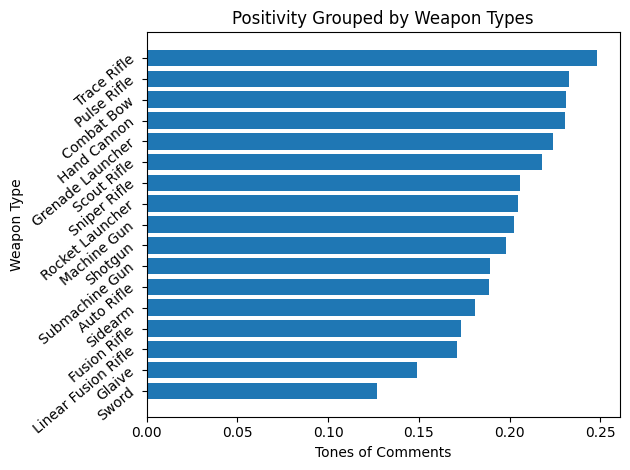

In [301]:
plt.barh(range(len(type_list)), type_tone)
plt.title('Positivity Grouped by Weapon Types')
plt.xlabel('Tones of Comments')
plt.ylabel('Weapon Type')
plt.yticks(range(len(type_list)), type_list, rotation = 40)
plt.tight_layout()
plt.show
plt.savefig("TypeTones.png", format="png", dpi=3600)

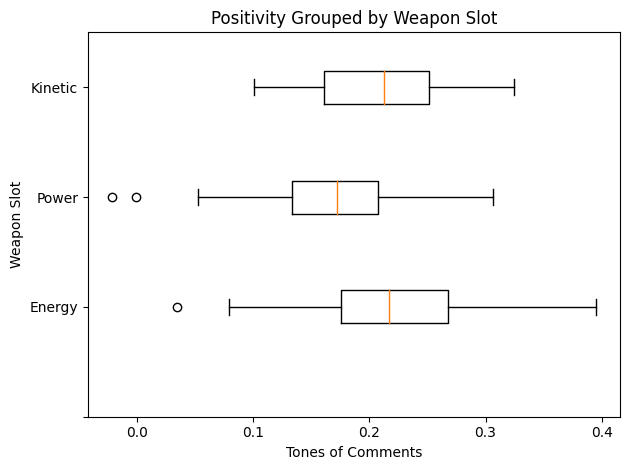

In [294]:
plt.boxplot(slot_tone, vert=False)
plt.title('Positivity Grouped by Weapon Slot')
plt.xlabel('Tones of Comments')
plt.ylabel('Weapon Slot')
plt.yticks(range(len(slot_list)), slot_list)
plt.tight_layout()
plt.show
plt.savefig("SlotTones.png", format="png", dpi=3600)

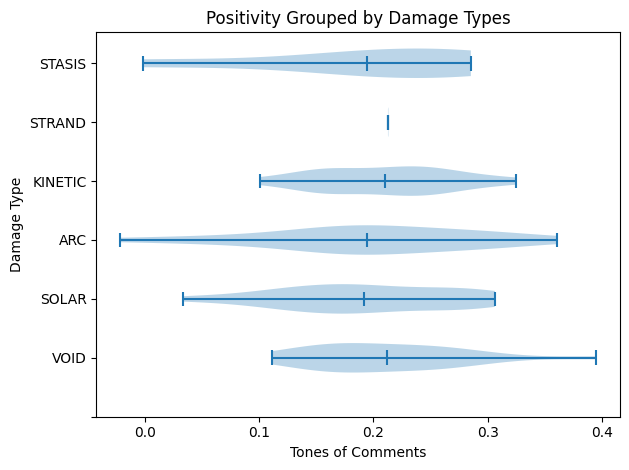

In [293]:
plt.violinplot(damage_tone, vert=False,showmeans=True)
plt.title('Positivity Grouped by Damage Types')
plt.xlabel('Tones of Comments')
plt.ylabel('Damage Type')
plt.yticks(range(len(damage_list)), damage_list)
plt.tight_layout()
plt.show
plt.savefig("DamageTones.png", format="png", dpi=3600)

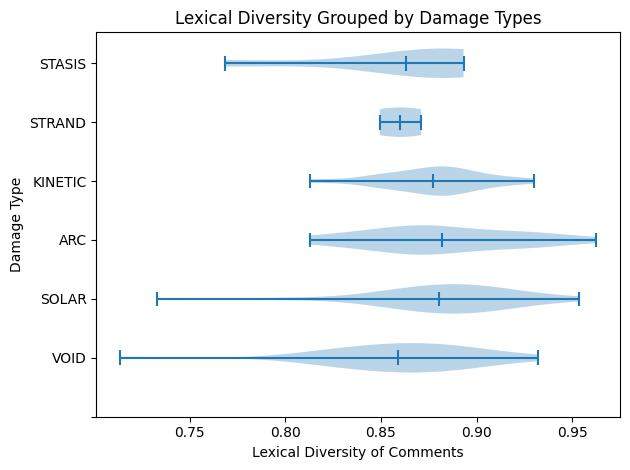

In [292]:
#Void, strand, stasis, kinetic, solar, arc
plt.violinplot(damage_lex, vert=False,showmeans=True)
plt.title('Lexical Diversity Grouped by Damage Types')
plt.xlabel('Lexical Diversity of Comments')
plt.ylabel('Damage Type')
plt.yticks(range(len(damage_list)), damage_list)
plt.tight_layout()
plt.show
plt.savefig("DamageLex.png", format="png", dpi=3600)

In [15]:
#unpickle sdoc
with open('Doc.pkl', 'rb') as f:
        doc = pickle.load(f)

In [210]:
not_stop = [token for token in doc if not token.is_stop]
nouns = [token for token in doc if not token.is_stop and token.pos_ == 'NOUN']
verbs = [token for token in doc if not token.is_stop and token.pos_ == 'VERB']

In [211]:
lemmas = map(lambda x: x.lemma_, nouns)
lemma_freqs = Counter(lemmas)
print(lemma_freqs.most_common(10), '\n')

vlemmas = map(lambda x: x.lemma_, verbs)
vlemma_freqs = Counter(vlemmas)
print(vlemma_freqs.most_common(10))

[('weapon', 890), ('damage', 678), ('gun', 655), ('thing', 478), ('shot', 322), ('range', 316), ('time', 308), ('pvp', 293), ('enemy', 287), ('perk', 274)] 

[('use', 537), ('kill', 337), ('get', 282), ('make', 234), ('feel', 204), ('need', 192), ('want', 170), ('hit', 167), ('go', 150), ('shoot', 146)]


In [281]:
n_labels, n_count = zip(*reversed(lemma_freqs.most_common(10)))
v_labels, v_count = zip(*reversed(vlemma_freqs.most_common(10)))

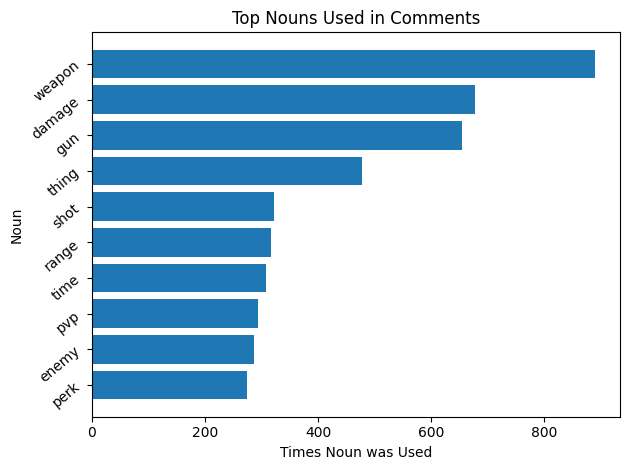

In [302]:
plt.barh(range(10), n_count)
plt.title('Top Nouns Used in Comments')
plt.xlabel('Times Noun was Used')
plt.ylabel('Noun')
plt.yticks(range(len(n_labels)), n_labels, rotation = 40)
plt.tight_layout()
plt.show
plt.savefig("TopNouns.png", format="png", dpi=3600)

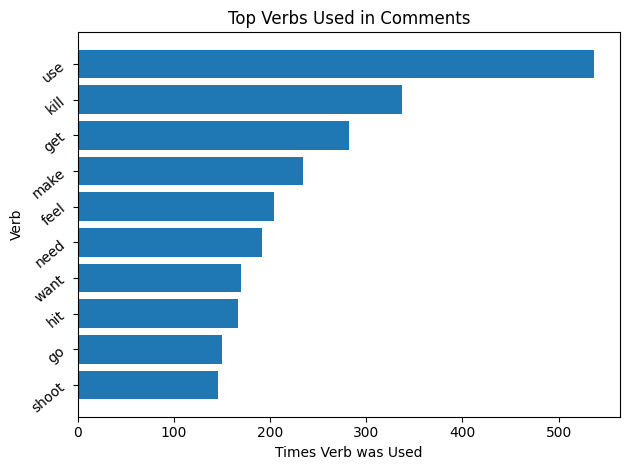

In [303]:
plt.barh(range(10), v_count)
plt.title('Top Verbs Used in Comments')
plt.xlabel('Times Verb was Used')
plt.ylabel('Verb')
plt.yticks(range(len(v_labels)), v_labels, rotation = 40)
plt.tight_layout()
plt.show
plt.savefig("TopVerbs.png", format="png", dpi=3600)

In [212]:
top_tone = -1
top_weapon = None
for weapon in soup:
    if soup[weapon]['Tone'] > top_tone:
        top_tone = soup[weapon]['Tone']
        top_weapon = weapon

In [213]:
from collections import OrderedDict
from operator import getitem
soup_by_tone = OrderedDict(sorted(soup.items(), key = lambda x: getitem(x[1], 'Tone')))
soup_by_tone = OrderedDict(reversed(list(soup_by_tone.items())))

In [252]:
print(bottom_weapons)

[]


In [249]:
top_weapons = []
top_weapons_tone = []
i = 0
for x in soup_by_tone:
    if i < 10:
        print(soup_by_tone[x])
        top_weapons.insert(0, soup_by_tone[x]['Name'])
        top_weapons_tone.insert(0, soup_by_tone[x]['Tone'])
        i += 1

{'Name': 'LE MONARQUE', 'Slot': 'Energy', 'Type': 'Combat Bow', 'Damage': 'VOID', 'Ammo': 'PRIMARY', 'Season': 'Season 5', 'Tone': 0.39495574855699855, 'Lexical': 0.8648029847911576}
{'Name': 'THE FOURTH HORSEMAN', 'Slot': 'Energy', 'Type': 'Shotgun', 'Damage': 'ARC', 'Ammo': 'SPECIAL', 'Season': 'Season 10', 'Tone': 0.3604958313291647, 'Lexical': 0.8610420244031232}
{'Name': 'ACE OF SPADES', 'Slot': 'Kinetic', 'Type': 'Hand Cannon', 'Damage': 'KINETIC', 'Ammo': 'PRIMARY', 'Season': 'Season 4', 'Tone': 0.32453963066708164, 'Lexical': 0.8679703227716815}
{'Name': 'NO TIME TO EXPLAIN', 'Slot': 'Kinetic', 'Type': 'Pulse Rifle', 'Damage': 'KINETIC', 'Ammo': 'PRIMARY', 'Season': 'Season 12', 'Tone': 0.31652733460746296, 'Lexical': 0.8598001845215071}
{'Name': 'DIVINITY', 'Slot': 'Energy', 'Type': 'Trace Rifle', 'Damage': 'ARC', 'Ammo': 'SPECIAL', 'Season': 'Season 8', 'Tone': 0.31026911690602177, 'Lexical': 0.9166603470839435}
{'Name': 'GJALLARHORN', 'Slot': 'Power', 'Type': 'Rocket Launche

In [260]:
bottom_weapons = []
bottom_weapons_tone = []
neg_soup_by_tone = reversed(list(soup_by_tone))
reverse_soup = list(neg_soup_by_tone)
i = 0
for x in reverse_soup:
    if i < 10:
        print(soup[x])
        bottom_weapons.insert(0, soup[x]['Name'])
        bottom_weapons_tone.insert(0, soup[x]['Tone'])
        i += 1

{'Name': 'WORLDLINE ZERO', 'Slot': 'Power', 'Type': 'Sword', 'Damage': 'ARC', 'Ammo': 'HEAVY', 'Season': 'Season 3', 'Tone': -0.02151400367309458, 'Lexical': 0.9319229152935253}
{'Name': 'WINTERBITE', 'Slot': 'Power', 'Type': 'Glaive', 'Damage': 'STASIS', 'Ammo': 'HEAVY', 'Season': 'Season 20', 'Tone': -0.0011748688503614674, 'Lexical': 0.887822724397677}
{'Name': 'MERCILESS', 'Slot': 'Energy', 'Type': 'Fusion Rifle', 'Damage': 'SOLAR', 'Ammo': 'SPECIAL', 'Season': 'Season 1', 'Tone': 0.03395810527276044, 'Lexical': 0.8751586886954396}
{'Name': 'LEGEND OF ACRIUS', 'Slot': 'Power', 'Type': 'Shotgun', 'Damage': 'ARC', 'Ammo': 'HEAVY', 'Season': 'Season 1', 'Tone': 0.05208333333333334, 'Lexical': 0.9625}
{'Name': 'WHISPER OF THE WORM', 'Slot': 'Power', 'Type': 'Sniper Rifle', 'Damage': 'SOLAR', 'Ammo': 'HEAVY', 'Season': 'Season 3', 'Tone': 0.0671494708994709, 'Lexical': 0.852812859342707}
{'Name': 'DELICATE TOMB', 'Slot': 'Energy', 'Type': 'Fusion Rifle', 'Damage': 'ARC', 'Ammo': 'SPECIA

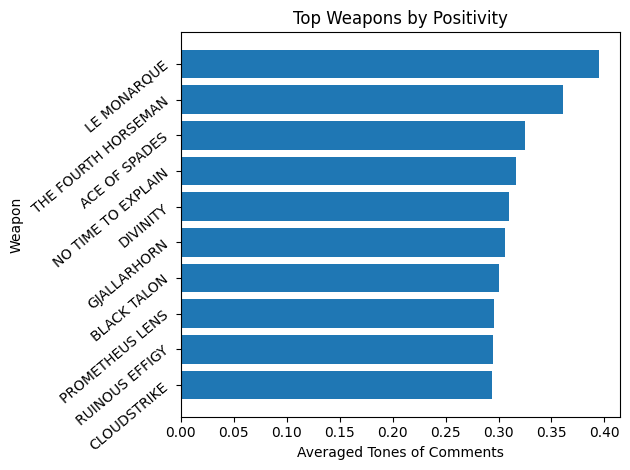

In [304]:
plt.barh(range(10), top_weapons_tone)
plt.title('Top Weapons by Positivity')
plt.xlabel('Averaged Tones of Comments')
plt.ylabel('Weapon')
plt.yticks(range(len(top_weapons)), top_weapons, rotation = 40)
plt.tight_layout()
plt.show
plt.savefig("TopTones.png", format="png", dpi=3600)

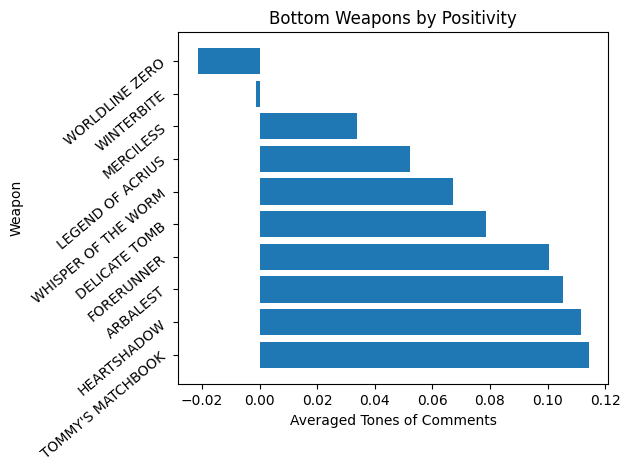

In [305]:
plt.barh(range(10), bottom_weapons_tone)
plt.title('Bottom Weapons by Positivity')
plt.xlabel('Averaged Tones of Comments')
plt.ylabel('Weapon')
plt.yticks(range(len(bottom_weapons)), bottom_weapons, rotation = 40)
plt.tight_layout()
plt.show
plt.savefig("BottomTones.png", format="png", dpi=3600)

In [285]:
t_lexdiv = []
t_senpol = []
for timebound in big_list:
    t_lexdiv.append(lexical_diversity(timebound))
    t_senpol.append(nlp(timebound)._.blob.sentiment.polarity)

super_pos = []
super_neg = []
for timebound in big_list:
    if nlp(timebound)._.blob.sentiment.polarity == -1.0:
        super_neg.append(timebound)
    if nlp(timebound)._.blob.sentiment.polarity == 1.0:
        super_pos.append(timebound)

print(super_pos)

print(super_neg)

print('Lexical Diversity, Min: ', round(min(t_lexdiv),2), ', Max: ', round(max(t_lexdiv),2), ', Average: ', round(sum(t_lexdiv)/len(t_lexdiv),2))
print('Sentiment, Min: ', round(min(t_senpol),2), ', Max: ', round(max(t_senpol),2), ', Average: ', round(sum(t_senpol)/len(t_senpol),2))


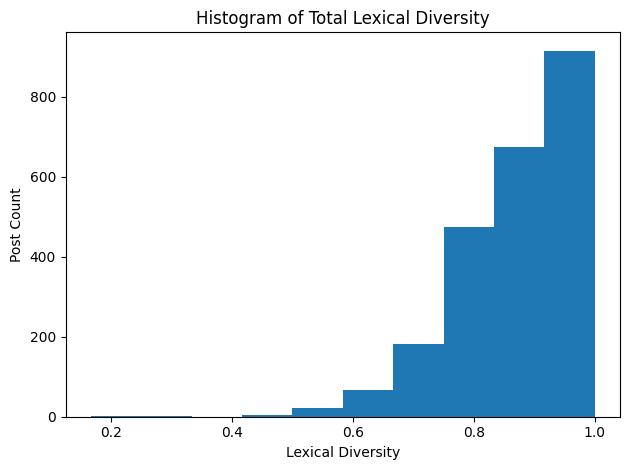

In [289]:
plt.hist(t_lexdiv)
plt.title('Histogram of Total Lexical Diversity')
plt.xlabel('Lexical Diversity')
plt.ylabel('Post Count')
plt.tight_layout()
plt.show
plt.savefig("TotalLex.png", format="png", dpi=3600)

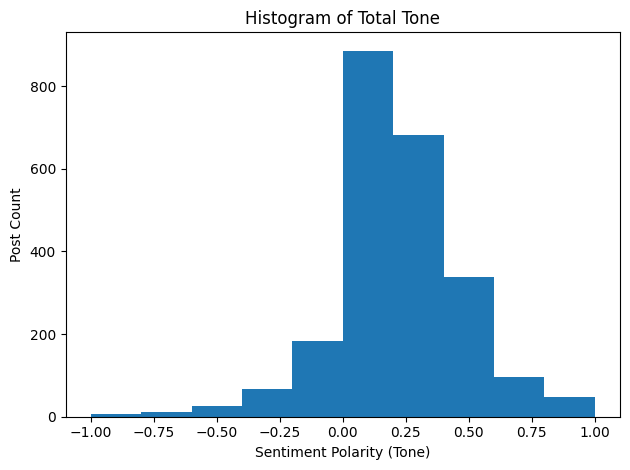

In [290]:
plt.hist(t_senpol)
plt.title('Histogram of Total Tone')
plt.xlabel('Sentiment Polarity (Tone)')
plt.ylabel('Post Count')
plt.tight_layout()
plt.show
plt.savefig("TotalTone.png", format="png", dpi=3600)